In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os

from kaggle_submit import submit_to_kaggle
from helpers import *

PICTURES_FOLDER = "pictures"
os.makedirs(PICTURES_FOLDER, exist_ok=True)

SLEEP_STAGES_COLORS = {
    0: "blue",
    1: "green",     
    2: "red",
    3: "black",
    4: "orange",
}

In [24]:
train_file = "kaggle_data/X_train.h5/X_train.h5"
test_file = "kaggle_data/X_test.h5/X_test.h5"

h5_train = h5py.File(train_file, mode='a')
h5_test = h5py.File(test_file, mode='a')

y_train = pd.read_csv("kaggle_data/y_train.csv", index_col=0, squeeze=True)

In [25]:
IRRELEVANT_FEATURES = ['index', 'index_absolute', 'index_window',
                       'x', 'y', 'z',
                       'speed_x', 'speed_y', 'speed_z']

def update_globals():
    features = [feat for feat in h5_train.keys() if feat not in IRRELEVANT_FEATURES]
    frequencies = {feat: h5_train[feat][0].size // 30 for feat in features}
    frequencies = {feat: freq if int(freq) in (10, 50) else 0 
                   for feat, freq in frequencies.items()}
    return features, frequencies
    
FEATURES, FREQUENCIES = update_globals()
print("FEATURES (sorted) =", sorted(FEATURES))
# print("FREQUENCIES =", FREQUENCIES)

FEATURES (sorted) = ['accel_norm', 'alpha_eeg_1_logE', 'alpha_eeg_2_logE', 'alpha_eeg_3_logE', 'alpha_eeg_4_logE', 'alpha_eeg_5_logE', 'alpha_eeg_6_logE', 'alpha_eeg_7_logE', 'beta_eeg_1_logE', 'beta_eeg_2_logE', 'beta_eeg_3_logE', 'beta_eeg_4_logE', 'beta_eeg_5_logE', 'beta_eeg_6_logE', 'beta_eeg_7_logE', 'delta_eeg_1_logE', 'delta_eeg_2_logE', 'delta_eeg_3_logE', 'delta_eeg_4_logE', 'delta_eeg_5_logE', 'delta_eeg_6_logE', 'delta_eeg_7_logE', 'eeg_1', 'eeg_2', 'eeg_3', 'eeg_4', 'eeg_5', 'eeg_6', 'eeg_7', 'pulse', 'pulse_max_freq', 'pulse_max_logE', 'sleep_left', 'sleep_time', 'sleep_time_relative', 'speed_norm', 'theta_eeg_1_logE', 'theta_eeg_2_logE', 'theta_eeg_3_logE', 'theta_eeg_4_logE', 'theta_eeg_5_logE', 'theta_eeg_6_logE', 'theta_eeg_7_logE']


In [26]:
# Example
# get_subject_feature_signals(h5_train, 1, "eeg_1", frequencies_dict=FREQUENCIES, as_timeseries=False)
# get_subject_feature_signals(h5_train, 1, "eeg_1", frequencies_dict=FREQUENCIES, as_timeseries=True)

In [27]:
from time_features import _create_time_features

_create_time_features(h5_train, overwrite=True, verbose=True)
_create_time_features(h5_test, overwrite=True, verbose=True)

from speed_and_accel import _create_speed_and_acceleration

# Create speed and acceleration
_create_speed_and_acceleration(h5_train, overwrite=False, verbose=True)
_create_speed_and_acceleration(h5_test, overwrite=False, verbose=True)
FEATURES, FREQUENCIES = update_globals()
print(FEATURES)

IndexError: index 31 is out of bounds for axis 0 with size 31

| Name     | Frequency (Hz)|
| ---------| -----------|
| $\delta$ | 0-4 |
| $\theta$ | 4-8 |
| $\alpha$ | 8-13 |
| $\beta$  | 13-22 |
| $\gamma$ | 30-. |


In [21]:
from eeg_band_log_energies import _create_log_energy

_create_log_energy(h5_train, n_chunks=100, overwrite=False, verbose=True)
_create_log_energy(h5_test, n_chunks=100, overwrite=False, verbose=True)
FEATURES, FREQUENCIES = update_globals()
# print("FEATURES =", FEATURES)
print("FREQUENCIES =", FREQUENCIES)

FREQUENCIES = {'accel_norm': 10, 'alpha_eeg_1_logE': 0, 'alpha_eeg_2_logE': 0, 'alpha_eeg_3_logE': 0, 'alpha_eeg_4_logE': 0, 'alpha_eeg_5_logE': 0, 'alpha_eeg_6_logE': 0, 'alpha_eeg_7_logE': 0, 'beta_eeg_1_logE': 0, 'beta_eeg_2_logE': 0, 'beta_eeg_3_logE': 0, 'beta_eeg_4_logE': 0, 'beta_eeg_5_logE': 0, 'beta_eeg_6_logE': 0, 'beta_eeg_7_logE': 0, 'delta_eeg_1_logE': 0, 'delta_eeg_2_logE': 0, 'delta_eeg_3_logE': 0, 'delta_eeg_4_logE': 0, 'delta_eeg_5_logE': 0, 'delta_eeg_6_logE': 0, 'delta_eeg_7_logE': 0, 'eeg_1': 50, 'eeg_2': 50, 'eeg_3': 50, 'eeg_4': 50, 'eeg_5': 50, 'eeg_6': 50, 'eeg_7': 50, 'pulse': 10, 'pulse_max_freq': 0, 'pulse_max_logE': 0, 'sleep_left': 0, 'sleep_time': 0, 'sleep_time_relative': 0, 'speed_norm': 10, 'theta_eeg_1_logE': 0, 'theta_eeg_2_logE': 0, 'theta_eeg_3_logE': 0, 'theta_eeg_4_logE': 0, 'theta_eeg_5_logE': 0, 'theta_eeg_6_logE': 0, 'theta_eeg_7_logE': 0}


In [22]:
from pulse_to_freq import _create_pulse_max_log_energy_and_freq

_create_pulse_max_log_energy_and_freq(h5_train, n_chunks=100, overwrite=False, verbose=True)
_create_pulse_max_log_energy_and_freq(h5_test, n_chunks=100, overwrite=False, verbose=True)

FEATURES, FREQUENCIES = update_globals()
print(FEATURES)

['accel_norm', 'alpha_eeg_1_logE', 'alpha_eeg_2_logE', 'alpha_eeg_3_logE', 'alpha_eeg_4_logE', 'alpha_eeg_5_logE', 'alpha_eeg_6_logE', 'alpha_eeg_7_logE', 'beta_eeg_1_logE', 'beta_eeg_2_logE', 'beta_eeg_3_logE', 'beta_eeg_4_logE', 'beta_eeg_5_logE', 'beta_eeg_6_logE', 'beta_eeg_7_logE', 'delta_eeg_1_logE', 'delta_eeg_2_logE', 'delta_eeg_3_logE', 'delta_eeg_4_logE', 'delta_eeg_5_logE', 'delta_eeg_6_logE', 'delta_eeg_7_logE', 'eeg_1', 'eeg_2', 'eeg_3', 'eeg_4', 'eeg_5', 'eeg_6', 'eeg_7', 'pulse', 'pulse_max_freq', 'pulse_max_logE', 'sleep_left', 'sleep_time', 'sleep_time_relative', 'speed_norm', 'theta_eeg_1_logE', 'theta_eeg_2_logE', 'theta_eeg_3_logE', 'theta_eeg_4_logE', 'theta_eeg_5_logE', 'theta_eeg_6_logE', 'theta_eeg_7_logE']


## VISUALIZATION

In [8]:
def robust_rescale(df):
    """
    X_rescaled = (X - MED(X)) / MED(|X - MED(X)|)
    """
    med = df.median()
    med_spread = (df - df.median()).abs().median()
    # df_rescaled = (df - med) / med_spread
    return (df - med) / med_spread

def min_max_rescale(df):
    min_ = df.min()
    max_ = df.max()
    return (df - min_) / (max_ - min_)
    
def z_rescale(df): 
    mean = df.mean()
    std = df.std()
    return (df - mean) / std

def get_fig_subjects():
    fig, axes = plt.subplots(10, 3, figsize=(10, 40))
    return fig, np.ravel(axes)

def title_with_subject_id(ax, subject_id):
    ax.set_title(f'SUBJECT #{subject_id}')
    return None

def save_feature_quantiles(feature,
                           inf_qt=0.025,
                           sup_qt=0.975,
                           n_quantiles=21,
                           robust_rescaling=False,
                           overwrite=False,
                           verbose=True):
    """
    See pictures/quantile_plots
    
    Can be improved (make robust and not robust qplots simultaneously)
    """
    # Make directory if it does not exist
    qplot_dir = os.path.join(PICTURES_FOLDER, f"quantile_plots")
    os.makedirs(qplot_dir, exist_ok=True)
    # Escape if not overwrite and already done
    qplot_fname = os.path.join(qplot_dir, f'{feature}{"--rescaled" if robust_rescaling else ""}.png')
    if (not overwrite) and os.path.exists(qplot_fname):
        return None
    # Otherwise,
    subject_ids = get_subject_ids(h5_train)
    quantiles = np.linspace(inf_qt, sup_qt, n_quantiles).round(3)
    subjects_quantiles = dict()
    for cnt, sid in enumerate(subject_ids):
        if verbose:
            print_bis(f"FEATURE #{FEATURES.index(feature)} SUBJECT {cnt+1}/{len(subject_ids)} (RESCALE = {str(robust_rescaling)})")
        # Robust representation of the signal
        signal = get_subject_feature_signals(h5_train, sid, feature, frequencies_dict=FREQUENCIES, as_timeseries=False)
        size = signal[0].size
        signal = pd.Series(np.concatenate(signal))
        if robust_rescaling:
            signal = robust_rescale(signal)
        # Behaviour by sleep stage
        sleep_stages = get_subject_sleep_stage(sid, h5_train, y_train).values
        signal_by_stage = signal.groupby(np.repeat(sleep_stages, size))
        subjects_quantiles[sid] = signal_by_stage.quantile(quantiles).unstack(0)
        
    fig, axes = get_fig_subjects()
    for ax, sid in zip(axes, subject_ids):
        subjects_quantiles[sid].plot(ax=ax)#, color=SLEEP_STAGES_COLORS)
        title_with_subject_id(ax, sid)
    plt.savefig(qplot_fname)
    plt.close(fig)
    return subjects_quantiles


# TO WRITE QUANTILE PLOTS IN pictures/quantile_plots
for i, feat in enumerate(FEATURES):
    # print_ter(f"========= FEATURE {i+1}/{len(FEATURES)} =========")
    save_feature_quantiles(feat, robust_rescaling=False, overwrite=False, verbose=True)
    save_feature_quantiles(feat, robust_rescaling=True, overwrite=False, verbose=True)


In [9]:
def get_proba_transition(subject_id=None):
    if subject_id:
        start, end = get_subject_boundaries(h5_train, subject_id, ready_to_use=False)
        y = y_train.loc[start:end]
    else: # all subjects
        y = y_train.loc[:]
    transition_df = pd.DataFrame(data={"stage": y, "stage_after": y.shift(-1)})
    transition_df = transition_df.iloc[:-1] # NaN
    transition_df = transition_df.astype(int)
    counts = transition_df.groupby(["stage", "stage_after"]).size()
    counts = counts.unstack(1, fill_value=0)
    probas = counts.div(counts.sum(axis=1), axis=0)
    probas = probas.reindex(range(0, 5), axis=0, fill_value=0)
    probas = probas.reindex(range(0, 5), axis=1, fill_value=0)
    return probas

transition_plots_dir = os.path.join(PICTURES_FOLDER, "transition_plots")
os.makedirs(transition_plots_dir, exist_ok=True)

def save_transition_plots_by_subject(overwrite=False, verbose=True):
    fpath = os.path.join(transition_plots_dir, "transition_matrix_by_subject.png")
    if (not overwrite) and os.path.exists(fpath):
        return None
    subject_ids = get_subject_ids(h5_train)
    fig, axes = get_fig_subjects()
    for ax, sid in zip(axes, subject_ids):
        if verbose:
            print_bis(f"SUBJECT #{sid}")
        probas = get_proba_transition(subject_id=sid)
        sns.heatmap(probas, ax=ax, vmin=0, vmax=1, annot=True)
        title_with_subject_id(ax, sid)
    fig.tight_layout()
    fig.savefig(fpath)
    plt.close(fig)    
    return None

def save_transition_plot_global(overwrite=False):
    fpath = os.path.join(transition_plots_dir, "transition_matrix_global.png")
    if (not overwrite) and os.path.exists(fpath):
        return None
    proba_global = get_proba_transition()
    fig, ax = plt.subplots()
    sns.heatmap(proba_global, ax=ax, vmin=0, vmax=1, annot=True)
    fig.savefig(fpath)
    plt.close(fig)
    return None
    
save_transition_plots_by_subject(overwrite=False)
save_transition_plot_global(overwrite=False)

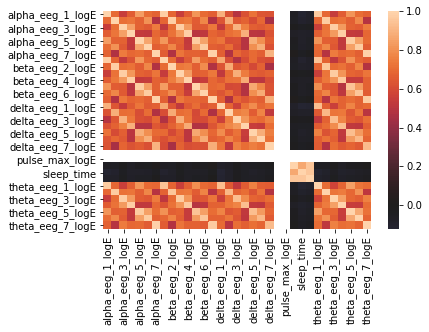

In [10]:
log_energies = [feature for feature, freq in FREQUENCIES.items() if freq == 0]
log_energies_df = pd.DataFrame({le: h5_train[le][:][:, 0] for le in log_energies})
sns.heatmap(log_energies_df.corr(), center=0)

In [11]:
sleep_stages_frequencies = y_train.groupby(y_train.values).count()
sleep_stages_frequencies

0    3511
1    1671
2    9449
3    5224
4    4833
Name: sleep_stage, dtype: int64

In [12]:
h5_train["index"].shape

(24688,)

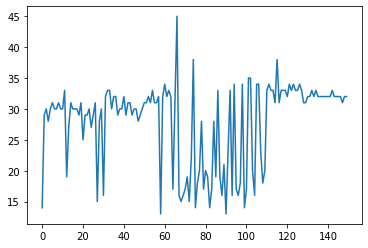

In [13]:
from scipy.fft import fft

def get_amplitudes(signals):
    fourier = fft(signals, axis=1)
    fourier = fourier[:int(np.ceil(fourier.shape[1] / 2))] # Shannon
    amplitudes = np.abs(fourier)
    return amplitudes

def get_max_amplitude_and_freq(signals, to_hertz=False, sampling_freq=None):
    assert (not to_hertz) or (to_hertz and (sampling_freq is not None))
    amplitudes = get_amplitudes(signals)
    argmax_frequencies = np.argmax(amplitudes, axis=1)
    max_amplitudes = amplitudes[list(range(amplitudes.shape[0])), argmax_frequencies]
    if to_hertz:
        argmax_frequencies *= sampling_freq / signals.shape[1]
    return max_amplitudes, argmax_frequencies

signals = h5_train["pulse"][15000:16000]
_, vv = get_max_amplitude_and_freq(signals, sampling_freq=10)
plt.plot(vv)

### 1. RANDOM FOREST

In [14]:
def moment(array,moments):
    res = np.empty((array.shape[0],len(moments)))
    for i in range(len(moments)):
        res[:,i] = np.mean(np.power(array,moments[i]), axis=1)
    return res

def make_input_feature(h5_file, feature, quantiles, moments=[1,2,3,4], n_chunks=100):
    print_bis(f"Feature #{FEATURES.index(feature)}")
    if FREQUENCIES[feature] == 0:
        return h5_file[feature][:]
    feature_array = np.empty(shape=(h5_file[feature].shape[0], len(quantiles)+len(moments)))
    for i, j in chunks_iterator(n_chunks, h5_file[feature].shape[0]):
        feature_array[i:j, :] = np.concatenate((np.quantile(h5_file[feature][i:j], quantiles, axis=1).T,
        moment(h5_file[feature][i:j],moments)),axis=1)
    return feature_array

def make_input(h5_file, features=None, quantiles=None):
    if features is None:
        features = FEATURES
    if quantiles is None:
        quantiles = QUANTILES
    return np.concatenate([make_input_feature(h5_file, feat, quantiles) for feat in features], axis=1)
    
def split_train_validation_subject_ids(train_perc, seed=None):
    np.random.seed(seed)
    subjects_ids = get_subject_ids(h5_train)
    shuffled_ids = np.random.permutation(subjects_ids)
    N_train = int(np.round(train_perc * len(shuffled_ids)))
    train_ids, validation_ids = shuffled_ids[:N_train], shuffled_ids[N_train:]
    return sorted(train_ids), sorted(validation_ids)

def subjects_ids_to_indexers(h5_file, subjects_ids, as_indices=False, as_boolean_array=False):
    if as_indices == as_boolean_array:
        raise NameError('Choose between `indices` and `boolean array` representations')
    if as_indices:
        boundaries = [get_subject_boundaries(h5_file, sid, ready_to_use=False) for sid in subjects_ids]
        return sum(map(lambda bounds: list(range(bounds[0], bounds[1]+1)), boundaries), list())
    if as_boolean_array:
        boolean_indexer = np.zeros(shape=(h5_file[FEATURES[0]].shape[0],), dtype=bool)
        for sid in subjects_ids:
            boolean_indexer[get_subject_boundaries(h5_file, sid, ready_to_use=True)] = True
        return boolean_indexer
        
    
def split_train_validation(X_train, 
                           train_subjects_ids=None, # ids for train
                           train_perc=None,
                           seed=None):
    if (train_subjects_ids is None) and (train_perc is None):
        raise NameError("Either `subjects_ids` or `train_perc` must be provided")
    if train_perc is not None:
        train_subjects_ids, _ = split_train_validation_subject_ids(train_perc, seed)
        return split_train_validation(X_train, train_subjects_ids=train_subjects_ids)
    
    train_selector = subjects_ids_to_indexers(h5_train, train_subjects_ids, as_boolean_array=True)
    X_train_train, y_train_train = X_train[train_selector], y_train.values[train_selector]
    X_train_val, y_train_val = X_train[~train_selector], y_train.values[~train_selector]
    
    return X_train_train, y_train_train, X_train_val, y_train_val

In [15]:
QUANTILES = [0.1, 0.5, 0.9]

quantiles_first_half = np.logspace(np.log10(0.025), np.log10(0.5), num=5).tolist()
QUANTILES_TAIL_CAPTURE = quantiles_first_half + [1 - q for q in quantiles_first_half[:-1]][::-1]
QUANTILES_TAIL_CAPTURE

[0.025000000000000005,
 0.05286856317202822,
 0.1118033988749895,
 0.2364354022507939,
 0.5,
 0.763564597749206,
 0.8881966011250105,
 0.9471314368279717,
 0.975]

In [16]:
X_train = make_input(h5_train, quantiles=QUANTILES_TAIL_CAPTURE)
X_test = make_input(h5_test, quantiles=QUANTILES_TAIL_CAPTURE)

KeyError: "Unable to open object (object 'sleep_left' doesn't exist)"

In [ ]:
X_train_train, y_train_train, X_train_val, y_train_val = split_train_validation(X_train, train_perc=0.7, seed=101)

In [ ]:
import time
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import fbeta_score

def get_eta_repr(elapsed, iteration, total_iterations):
    if iteration == 0:
        return "?"
    else:
        eta = (elapsed / iteration) * (total_iterations - iteration)
        return str(np.round(eta, 2)) + "s"
    
    
def train_on_grid(model_blueprint, params_grid, X, y):
    # Random shuffling of parameters for better ETA
    shuffled_ix = np.random.permutation(range(len(params_grid))) # for better ETA
    
    models = [None for _ in range(len(params_grid))] 
    elapsed_time = 0
    time_start = time.time()

    for i, ix in enumerate(shuffled_ix):
        print_bis(f"Training Model #{i+1}/{len(params_grid)} " +\
                  f"[ETA: {get_eta_repr(time.time() - time_start, i, len(params_grid))}]")
        model = model_blueprint(**params_grid[ix])
        model.fit(X, y)
                
        models[ix] = model
        
    return models

In [ ]:
from sklearn.ensemble import RandomForestClassifier


random_forest_params = {
    "n_estimators": [10, 30, 100, 150],
    "max_depth": [3, 10, 30, 100],
    "min_samples_leaf": [1, 10, 100]}

random_forest_params_grid = list(ParameterGrid(random_forest_params))

random_forest_models = train_on_grid(
    RandomForestClassifier, 
    random_forest_params_grid,
    X_train_train,
    y_train_train
)

In [ ]:
def custom_score(y_pred, y_true, average):
    return fbeta_score(y_pred=y_pred,
                       y_true=y_true,
                       labels=[0, 1, 2, 3, 4],
                       average=average,
                       beta=1)

def get_models_custom_scoring(models, X_train_train, y_train_train, X_train_val, y_train_val,
                             averages=['macro', 'micro']):
    scores = list()
    time_start = time.time()
    
    for i, model in enumerate(models):
        eta = get_eta_repr(time.time() - time_start, i, len(models))
        print_bis(f"Scoring Model #{i}/{len(models)} [ETA: {eta}]")
        
        y_train_pred = model.predict(X_train_train)
        y_val_pred = model.predict(X_train_val)
        model_scores = {f"train_{avg}": custom_score(y_train_pred, y_train_train, average=avg) for avg in averages}
        model_scores.update(
            {f"validation_{avg}": custom_score(y_val_pred, y_train_val, average=avg) for avg in averages}
        )
        
        
        scores.append(model_scores)
    return scores


In [82]:
random_forest_scores = get_models_custom_scoring(
    random_forest_models,
    X_train_train,
    y_train_train,
    X_train_val,
    y_train_val
)
                   
random_forest_results = pd.concat([pd.DataFrame(random_forest_params_grid), pd.DataFrame(random_forest_scores)],
                                  keys=['params', 'scores'],
                                  axis=1)

random_forest_results = random_forest_results.sort_values(
    by=[('scores', 'validation_macro'), ('scores', 'validation_micro')], 
    ascending=False
)
random_forest_results

params                                    scores              \
   max_depth min_samples_leaf n_estimators train_macro train_micro   
26        30                1          100    0.999862    0.999894   
38       100                1          100    1.000000    1.000000   
27        30                1          150    1.000000    1.000000   
39       100                1          150    1.000000    1.000000   
31        30               10          150    0.789675    0.886213   
25        30                1           30    0.999530    0.999681   
43       100               10          150    0.790492    0.886851   
42       100               10          100    0.788576    0.885309   
30        30               10          100    0.792961    0.887063   
14        10                1          100    0.794727    0.860105   
41       100               10           30    0.790886    0.882756   
18        10               10          100    0.712966    0.821928   
37       100                1           30    0.998868    0.999256   
15        10                1          150    0.795553    0.861594   
19        10               10          150    0.711189    0.823364   
29        30               10           30    0.791133    0.882597   
28        30               10           10    0.778670    0.867815   
17        10               10           30    0.716316    0.818897   
40       100               10           10    0.781577    0.871112   
13        10                1           30    0.791045    0.855373   
36       100                1           10    0.993223    0.993992   
16        10               10           10    0.700818    0.803371   
12        10                1           10    0.776743    0.843728   
46       100              100          100    0.591629    0.724252   
47       100              100          150    0.586844    0.719892   
21        10              100           30    0.584088    0.715372   
35        30              100          150    0.588544    0.720849   
33        30              100           30    0.585537    0.717446   
24        30                1           10    0.992563    0.994151   
34        30              100          100    0.587081    0.719200   
22        10              100          100    0.582810    0.715744   
32        30              100           10    0.583035    0.714734   
45       100              100           30    0.583899    0.716276   
23        10              100          150    0.585105    0.717499   
44       100              100           10    0.576025    0.707290   
20        10              100           10    0.576191    0.707768   
8          3              100           10    0.467363    0.593396   
3          3                1          150    0.458671    0.591110   
4          3               10           10    0.453904    0.584091   
9          3              100           30    0.456791    0.590631   
11         3              100          150    0.460631    0.592864   
6          3               10          100    0.461350    0.593396   
10         3              100          100    0.458078    0.589834   
5          3               10           30    0.456073    0.587069   
1          3                1           30    0.457919    0.589621   
7          3               10          150    0.457344    0.589302   
2          3                1          100    0.457494    0.589036   
0          3                1           10    0.445883    0.574307   

                                      
   validation_macro validation_micro  
26         0.561232         0.661792  
38         0.560107         0.661112  
27         0.559933         0.661622  
39         0.557715         0.657031  
31         0.556207         0.661622  
25         0.554193         0.650570  
43         0.553178         0.659752  
42         0.550788         0.657031  
30         0.550502         0.660092  
14         0.550220         0.659582  
41         0.550129         0.652780 

In [83]:
def get_best_model(models, params_grid, scores, criterion="validation_macro"):
    ix_best_score = np.argmax([s[criterion] for s in scores])
    best_model = models[ix_best_score]
    best_model_params = params_grid[ix_best_score]
    best_model_score = scores[ix_best_score]
    return best_model, best_model_params, best_model_score



In [84]:
best_random_forest_model, _, _ = get_best_model(random_forest_models, random_forest_params_grid, random_forest_scores)
    
prediction = best_random_forest_model.predict(X_test)
#submission_file = save_for_submission(prediction)
#send_submission_to_kaggle(submission_file, )

### 2. SUPPORT VECTOR MACHINES

In [85]:
# make input for SVM

LOG_ENERGY_FEATURES = [feature for feature in FEATURES if feature.endswith("logE")]
SVM_FEATURES = [*LOG_ENERGY_FEATURES, "pulse", "speed_norm", "accel_norm"]

X_train = make_input(h5_train, features=SVM_FEATURES, quantiles=QUANTILES_TAIL_CAPTURE)
X_test = make_input(h5_test, features=SVM_FEATURES, quantiles=QUANTILES_TAIL_CAPTURE)

train_ids, validation_ids = split_train_validation_subject_ids(0.7, seed=101)
X_train_train, y_train_train, X_train_val, y_train_val = split_train_validation(X_train, train_subjects_ids=train_ids)

### PCA on log_energy features
from sklearn.decomposition import PCA

pca_logE = PCA(0.9)
pca_logE.fit(X_train_train[:, :len(LOG_ENERGY_FEATURES)])

def apply_pca(X, pca, copy=True):
    if copy:
        return apply_pca(X[:, :], pca, copy=False)
    X_transformed = pca.transform(X[:, :len(LOG_ENERGY_FEATURES)])
    X[:, len(LOG_ENERGY_FEATURES) - pca.n_components_ : len(LOG_ENERGY_FEATURES)] = X_transformed
    X = X[:, len(LOG_ENERGY_FEATURES) - pca.n_components_ :]
    return X

X_train_train = apply_pca(X_train_train, pca_logE)
X_train_val = apply_pca(X_train_val, pca_logE)
X_test = apply_pca(X_test, pca_logE)

### Rescaling
from sklearn.preprocessing import StandardScaler 
# already robust on not logE features because we take quantiles
# --> StandardScaler 

z_scaler = StandardScaler()

X_train_train = z_scaler.fit_transform(X_train_train)
X_train_val = z_scaler.transform(X_train_val)
X_test = z_scaler.transform(X_test)

### SVC Models
from sklearn.svm import SVC

svm_params_grid_rbf_and_sigmoid = ParameterGrid(
    {"kernel": ["rbf", "sigmoid"],
     "C": [0.1, 1, 10],
     "gamma": ["scale", "auto"]
    })

svm_params_grid_poly = ParameterGrid(
    {"kernel": ["poly"],
     "C": [0.1, 1, 10],
     "degree": [3, 10] #if max_iter != -1
    })
 
svm_params_grid = list(svm_params_grid_rbf_and_sigmoid) + list(svm_params_grid_poly)

svm_models = train_on_grid(SVC, svm_params_grid, X_train_train, y_train_train)

In [86]:
svm_scores = get_models_custom_scoring(svm_models, X_train_train, y_train_train, X_train_val, y_train_val)
svm_scores

[{'train_macro': 0.34906001481735155,
  'train_micro': 0.5051310682192801,
  'validation_macro': 0.2763904479917661,
  'validation_micro': 0.4335997279374256},
 {'train_macro': 0.2614320675993827,
  'train_micro': 0.369011538257032,
  'validation_macro': 0.25364166732316773,
  'validation_micro': 0.3479000170039109},
 {'train_macro': 0.34906001481735155,
  'train_micro': 0.5051310682192801,
  'validation_macro': 0.2763904479917661,
  'validation_micro': 0.4335997279374256},
 {'train_macro': 0.2614320675993827,
  'train_micro': 0.369011538257032,
  'validation_macro': 0.25364166732316773,
  'validation_micro': 0.3479000170039109},
 {'train_macro': 0.4425298480449335,
  'train_micro': 0.5605891423406179,
  'validation_macro': 0.3625099634566772,
  'validation_micro': 0.4762795442951879},
 {'train_macro': 0.2701379314099138,
  'train_micro': 0.352634657308449,
  'validation_macro': 0.2471371194507579,
  'validation_micro': 0.3239245026356062},
 {'train_macro': 0.4425298480449335,
  'train

In [87]:
svm_scores = scores
best_svm_model, best_svm_params, best_svm_scores = \
    get_best_model(svm_models, svm_params_grid, svm_scores, criterion="validation_macro")
best_svm_scores

NameError: name 'scores' is not defined

In [ ]:
# svm_prediction = best_svm_model.predict(X_test)
# svm_submission = save_for_submission(svm_prediction)
# send_submission(svm_submission, "--")

In [24]:
h5_train.close()
h5_test.close()